In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import string as str
import seaborn as sns
import os
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from scipy import interp
import statsmodels.api as sm

In [2]:
df = pd.read_csv('./data/social_leads_aug_sept_clean.csv')

/Users/joehardy/Dev/ML/ML_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (40,43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Income
#Is U.S. Veteran
#Precise Age
#audience
#Landing URL
#creative
#Browser
#Android / iOS

In [4]:
def make_date_cols(df):
    df['lead_creation_datetime'] = pd.to_datetime(pd.Series(df['Lead Creation Datetime']))
    df['created_date'] = pd.to_datetime(pd.Series(df['Created Date']))
  #  df['datetime_of_first_call'] = pd.to_datetime(pd.Series(df['DateTime Of First Call']))
    df['converted_date'] = pd.to_datetime(pd.Series(df['Converted Date']))
    return(df)

In [5]:
df = make_date_cols(df)

In [6]:
df.columns

Index(['Lead Creation Datetime', 'Created Date', 'Lead ID', 'First Name',
       'Last Name', 'act', 'Customer browser language', 'Landing URL',
       'Browser', 'Android / iOS', 'User Device', 'Usage',
       'Controlling Channel', 'Marketing Partner', 'Marketing offer',
       'Lead Status', 'Reason for closing of lead', 'Converted',
       'Opportunity ID', 'Converted Date', 'Stage', 'Last quote',
       'Reason for closed and lost', 'Searching for', 'Experience',
       'Age of current hearing aid', 'Currently looking for hearing aids',
       'Visited ENT or audiologist', 'Recent hearing test', 'Why not sooner?',
       'COSI Basic Subtype 1', 'Discreet design', 'Tinnitus',
       'Purchase timeframe', 'Professional status', 'Income',
       'Income Reformatted', 'Willingness to invest', 'Is U.S. Veteran',
       'Exposed to loud noises', 'Mobile', 'Phone', 'Email', 'Precise Age',
       'Zip/Postal Code', 'Dynamic Marketing Comment', 'Video / Img',
       'audience', 'creative',

In [7]:
ct_conversions_income = pd.crosstab(index=df['Converted'], columns = [df['Income']])

In [8]:
ct_conversions_income

Income,"$30,000 ? $49,999","$30,000-$49,999","$50,000 ? $69,999","$50,000 to $69,999","$50,000-$69,999","$70,000 ? $89,999","$70,000-$89,999",Under 39 years-old,Unsure,"less than $30,000","more than $90,000"
Converted,,,,,,,,,,,
0,1672,18,2570,10,6,3185,10,1,21,2692,5595
1,127,2,224,0,0,318,2,0,0,169,521


In [9]:
ct_conversions_income.columns

Index(['$30,000 ? $49,999', '$30,000-$49,999', '$50,000 ? $69,999',
       '$50,000 to $69,999', '$50,000-$69,999', '$70,000 ? $89,999',
       '$70,000-$89,999', 'Under 39 years-old', 'Unsure', 'less than $30,000',
       'more than $90,000'],
      dtype='object', name='Income')

In [10]:
#less than $30,000	– Poor (0-639)
#$30,000 – $49,999	– Don't know
#$50,000 – $69,999	– Fair (640-679)
#$70,000 – $89,999	– Good (680-719)
#more than $90,000	– Excellent (720-850)

In [11]:
ct_conversions_credit = ct_conversions_income['$30,000 ? $49,999'] +   ct_conversions_income['$30,000-$49,999']

In [12]:
ct_conversions_income_rf = pd.crosstab(index=df['Converted'], columns = [df['Income Reformatted']])

In [13]:
ct_conversions_income_rf

Income Reformatted,"$30,000 - $49,999","$50,000 - $69,999","$70,000 - $89,999",< $30k,> $90k,Unsure
Converted,,,,,,
0,1690,2586,3195,2692,5595,22
1,129,224,320,169,521,0


In [14]:
ct_conversions_income_rf.columns

Index(['$30,000 - $49,999', '$50,000 - $69,999', '$70,000 - $89,999', '< $30k',
       '> $90k', 'Unsure'],
      dtype='object', name='Income Reformatted')

In [15]:
cr2_income = ct_conversions_income_rf.iloc[1] / (ct_conversions_income_rf.iloc[0] + ct_conversions_income_rf.iloc[1])


In [16]:
cr2_income

Income Reformatted
$30,000 - $49,999    0.070918
$50,000 - $69,999    0.079715
$70,000 - $89,999    0.091038
< $30k               0.059070
> $90k               0.085186
Unsure               0.000000
dtype: float64

In [17]:
income_credit = {"$30,000 - $49,999": "Don't know",
                 "Unsure": "Don't know",
                 "< $30k" : "Poor",
                 "$50,000 - $69,999": "Fair",
                 "$70,000 - $89,999": "Good",
                 "> $90k": "Excellent"}

In [18]:
df['Credit score'] = df['Income Reformatted'].map(income_credit)

In [19]:
# We might anticipate that not filling in the value for credit score
# would be more similar to entering "Don't know" than anything else.
# Last observation forward would also work, but might be difficult to implement in practice.
# Could also use NaN as a category -- pd.get_dummies(s1, dummy_na=True)
df['Credit score filled'] = df['Credit score'].fillna("Don't know")

In [20]:
ct_conversions_credit = pd.crosstab(index=df['Converted'], columns = [df['Credit score']])

In [21]:
ct_conversions_credit

Credit score,Don't know,Excellent,Fair,Good,Poor
Converted,,,,,
0,1712,5595,2586,3195,2692
1,129,521,224,320,169


In [22]:
cr2_credit = ct_conversions_credit.iloc[1] / (ct_conversions_credit.iloc[0] +  ct_conversions_credit.iloc[1])

In [23]:
cr2_credit

Credit score
Don't know    0.070071
Excellent     0.085186
Fair          0.079715
Good          0.091038
Poor          0.059070
dtype: float64

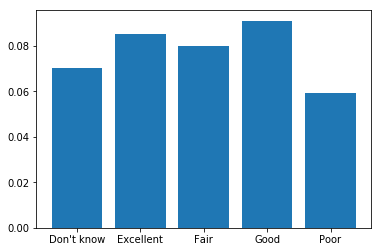

In [24]:
f = plt.bar(x=cr2_credit.index, height=cr2_credit.values)

In [25]:
cr2_credit_ri = cr2_credit.reindex(index = ["Don't know",'Poor','Fair','Good','Excellent'])

Text(0.5,0,'Credit score')

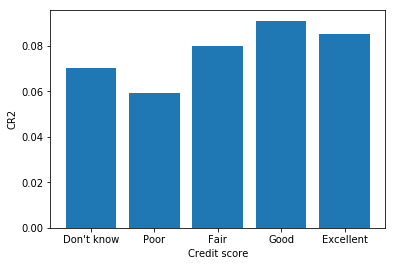

In [26]:
fig, ax = plt.subplots()
b = plt.bar(x=cr2_credit_ri.index, height=cr2_credit_ri.values)
ax.set_ylabel('CR2')
ax.set_xlabel('Credit score')

In [27]:
df['Numeric Age'] = pd.to_numeric(df['Precise Age'],errors='coerce')

In [28]:
df['Numeric Age'].mean()

67.12905295078143

In [29]:
df['Numeric Age Filled'] = df['Numeric Age'].fillna(method='ffill')

/Users/joehardy/Dev/ML/ML_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


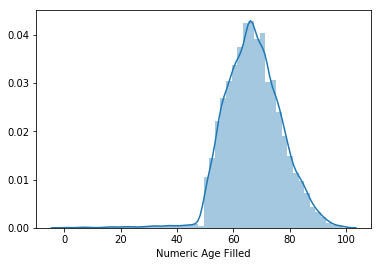

In [30]:
sns.distplot(df['Numeric Age Filled'])

In [31]:
df_age = df[(df['Numeric Age'] > 18) & (df['Numeric Age'] < 95)]

/Users/joehardy/Dev/ML/ML_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


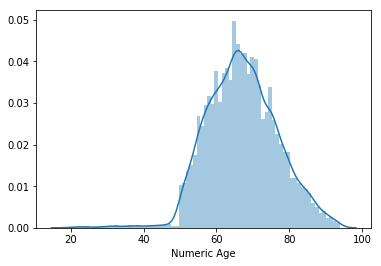

In [32]:
sns.distplot(df_age['Numeric Age'],bins = 76)

In [33]:
df_age.groupby('Converted').mean()

,Phone,Numeric Age,Numeric Age Filled
Converted,,,
0,1.629435e+10,67.309133,67.309133
1,1.629761e+10,65.336006,65.336006


/Users/joehardy/Dev/ML/ML_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


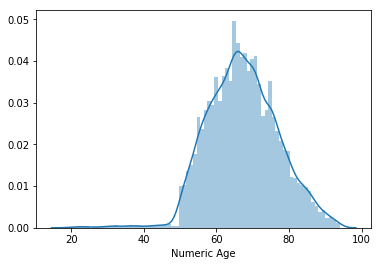

In [34]:
sns.distplot(df_age[df_age['Converted']==0]['Numeric Age'],bins = 76)

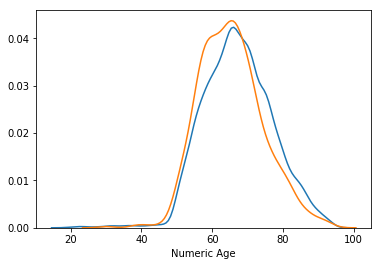

In [35]:
sns.distplot(df_age[df_age['Converted']==0]['Numeric Age'],bins = 76,hist=False)
sns.distplot(df_age[df_age['Converted']==1]['Numeric Age'],bins = 76,hist=False)

In [36]:
df_credit_dummies = pd.get_dummies(df['Credit score filled'], prefix='credit_')

In [37]:
converted = df["Converted"]

In [38]:
df = pd.concat([df,df_credit_dummies],axis=1)

In [39]:
df.columns

Index(['Lead Creation Datetime', 'Created Date', 'Lead ID', 'First Name',
       'Last Name', 'act', 'Customer browser language', 'Landing URL',
       'Browser', 'Android / iOS', 'User Device', 'Usage',
       'Controlling Channel', 'Marketing Partner', 'Marketing offer',
       'Lead Status', 'Reason for closing of lead', 'Converted',
       'Opportunity ID', 'Converted Date', 'Stage', 'Last quote',
       'Reason for closed and lost', 'Searching for', 'Experience',
       'Age of current hearing aid', 'Currently looking for hearing aids',
       'Visited ENT or audiologist', 'Recent hearing test', 'Why not sooner?',
       'COSI Basic Subtype 1', 'Discreet design', 'Tinnitus',
       'Purchase timeframe', 'Professional status', 'Income',
       'Income Reformatted', 'Willingness to invest', 'Is U.S. Veteran',
       'Exposed to loud noises', 'Mobile', 'Phone', 'Email', 'Precise Age',
       'Zip/Postal Code', 'Dynamic Marketing Comment', 'Video / Img',
       'audience', 'creative',

In [40]:
#model_columns = ["credit__Don't know", 'credit__Poor', 'credit__Excellent',
#                 'credit__Fair', 'credit__Good','Numeric Age Filled']
model_columns = ["credit__Don't know", 'credit__Poor', 'credit__Excellent',
                 'credit__Fair', 'credit__Good','Numeric Age Filled']

In [41]:
df_model_data = df[model_columns]

In [42]:
logit_model=sm.Logit(converted,df_model_data)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.274311
         Iterations 7
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.010     
Dependent Variable:  Converted        AIC:              9575.5904 
Date:                2018-10-14 20:28 BIC:              9622.1868 
No. Observations:    17432            Log-Likelihood:   -4781.8   
Df Model:            5                LL-Null:          -4828.8   
Df Residuals:        17426            LLR p-value:      9.9310e-19
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      7.0000                                       
------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------
credit__Don't know -1.1021   0.1993 -5.5291 0.0000 -1.4928 -0.7115
credit__Poor       -1.3645   0.1880 -7.2570 0.0000 -1

In [43]:
#['Is U.S. Veteran',
#'Exposed to loud noises']

In [44]:
df['Is U.S. Veteran'].value_counts()

No        15309
Yes        1933
Unsure        2
Name: Is U.S. Veteran, dtype: int64

In [45]:
15309+1933+2

17244

In [46]:
vet_yes_no = {"No": 0,
             "Unsure": 0,
             "Yes": 1}

In [47]:
df['Vet filled'] = df['Is U.S. Veteran'].map(vet_yes_no)

In [48]:
df['Vet filled'] = df['Vet filled'].fillna(0)

In [49]:
df['Vet filled'].value_counts()

0.0    15499
1.0     1933
Name: Vet filled, dtype: int64

In [50]:
15499 + 1933

17432

In [51]:
df['Vet filled'].shape

(17432,)

In [52]:
model_columns = ["credit__Don't know", 'credit__Poor', 'credit__Excellent',
                 'credit__Fair', 'credit__Good','Numeric Age Filled',
                 'Vet filled']
df_model_data = df[model_columns]

In [53]:
logit_model=sm.Logit(converted,df_model_data)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.269829
         Iterations 8
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.026     
Dependent Variable:  Converted        AIC:              9421.3208 
Date:                2018-10-14 20:28 BIC:              9475.6833 
No. Observations:    17432            Log-Likelihood:   -4703.7   
Df Model:            6                LL-Null:          -4828.8   
Df Residuals:        17425            LLR p-value:      3.6815e-51
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      8.0000                                       
------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------
credit__Don't know -1.1158   0.2025 -5.5101 0.0000 -1.5126 -0.7189
credit__Poor       -1.3832   0.1905 -7.2592 0.0000 -1

In [54]:
#'Exposed to loud noises'

In [55]:
ct_conversions_iOS = pd.crosstab(index=df['Converted'], columns = [df['Android / iOS']])

In [56]:
ct_conversions_iOS

Android / iOS,iOS,other
Converted,,
0,8287,7763
1,748,634


In [57]:
cr2_iOS = ct_conversions_iOS.iloc[1] / (ct_conversions_iOS.iloc[0] + ct_conversions_iOS.iloc[1])

In [58]:
cr2_iOS.values

array([0.08278915, 0.07550316])

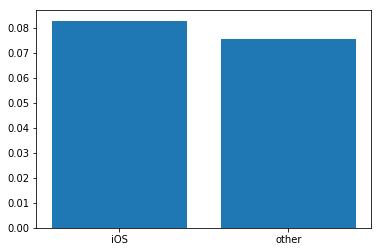

In [59]:
f = plt.bar(x=cr2_iOS.index, height=cr2_iOS.values)

In [60]:
iOS_other = {"iOS": 1,
             "other": 0}

In [61]:
df['iOS'] = df['Android / iOS'].map(iOS_other)

In [62]:
df['iOS'].value_counts()

1    9035
0    8397
Name: iOS, dtype: int64

In [63]:
model_columns = ["credit__Don't know", 'credit__Poor', 'credit__Excellent',
                 'credit__Fair', 'credit__Good','Numeric Age Filled',
                 'Vet filled', 'iOS']
df_model_data = df[model_columns]

In [64]:
logit_model=sm.Logit(converted,df_model_data)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.269809
         Iterations 8
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.026     
Dependent Variable:  Converted        AIC:              9422.6251 
Date:                2018-10-14 20:28 BIC:              9484.7536 
No. Observations:    17432            Log-Likelihood:   -4703.3   
Df Model:            7                LL-Null:          -4828.8   
Df Residuals:        17424            LLR p-value:      1.7692e-50
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      8.0000                                       
------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------
credit__Don't know -1.1341   0.2037 -5.5688 0.0000 -1.5332 -0.7349
credit__Poor       -1.3998   0.1916 -7.3076 0.0000 -1

In [65]:
exposed_yes_no = {"No": 0,
                  "Unsure": 0,
                  "Yes": 1}
df['Exposed filled'] = df['Exposed to loud noises'].map(vet_yes_no)

In [66]:
df['Exposed filled'] = df['Exposed filled'].fillna(0)

In [67]:
model_columns = ["credit__Don't know", 'credit__Poor', 'credit__Excellent',
                 'credit__Fair', 'credit__Good','Numeric Age Filled',
                 'Exposed filled', 'iOS']
df_model_data = df[model_columns]

In [68]:
logit_model=sm.Logit(converted,df_model_data)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.267438
         Iterations 11
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.035     
Dependent Variable:  Converted        AIC:              9339.9493 
Date:                2018-10-14 20:28 BIC:              9402.0778 
No. Observations:    17432            Log-Likelihood:   -4662.0   
Df Model:            7                LL-Null:          -4828.8   
Df Residuals:        17424            LLR p-value:      3.9998e-68
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      11.0000                                      
------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------
credit__Don't know -1.1197   0.2023 -5.5361 0.0000 -1.5161 -0.7233
credit__Poor       -1.3808   0.1904 -7.2534 0.0000 -

In [69]:
ha_age = {"0-2 years": 'none',
          "2-4 years": 'none',
          "4-5 years": 'none',
          "More than 5 years": 'none',
          "1 year": "1 year",
          "2 years": "2 years",
          "3 years": "3 years",
          "4 years": "4 years",
          "5 years": "5 years"}
df['HA age filled'] = df['Age of current hearing aid'].map(ha_age)

In [70]:
ct_conversions_HA_age = pd.crosstab(index=df['Converted'], columns = [df['HA age filled']])
cr2_HA_age = ct_conversions_HA_age.iloc[1] / (ct_conversions_HA_age.iloc[0] + ct_conversions_HA_age.iloc[1])

In [71]:
cr2_HA_age

HA age filled
1 year     0.020619
2 years    0.037700
3 years    0.065556
4 years    0.057692
5 years    0.063472
none       0.899160
dtype: float64

In [72]:
df['HA age filled'] = df['HA age filled'].fillna('No HA')

In [73]:
df_HA_age_filled = pd.get_dummies(df['HA age filled'], prefix='HA_age')
df = pd.concat([df,df_HA_age_filled],axis=1)

In [74]:
df.columns

Index(['Lead Creation Datetime', 'Created Date', 'Lead ID', 'First Name',
       'Last Name', 'act', 'Customer browser language', 'Landing URL',
       'Browser', 'Android / iOS', 'User Device', 'Usage',
       'Controlling Channel', 'Marketing Partner', 'Marketing offer',
       'Lead Status', 'Reason for closing of lead', 'Converted',
       'Opportunity ID', 'Converted Date', 'Stage', 'Last quote',
       'Reason for closed and lost', 'Searching for', 'Experience',
       'Age of current hearing aid', 'Currently looking for hearing aids',
       'Visited ENT or audiologist', 'Recent hearing test', 'Why not sooner?',
       'COSI Basic Subtype 1', 'Discreet design', 'Tinnitus',
       'Purchase timeframe', 'Professional status', 'Income',
       'Income Reformatted', 'Willingness to invest', 'Is U.S. Veteran',
       'Exposed to loud noises', 'Mobile', 'Phone', 'Email', 'Precise Age',
       'Zip/Postal Code', 'Dynamic Marketing Comment', 'Video / Img',
       'audience', 'creative',

In [75]:
model_columns = ["credit__Don't know", 'credit__Poor', 'credit__Excellent',
                 'credit__Fair', 'credit__Good','Numeric Age Filled',
                 'Exposed filled', 'iOS', 'HA_age_1 year', 'HA_age_2 years',
       'HA_age_3 years', 'HA_age_4 years', 'HA_age_5 years', 'HA_age_No HA']
df_model_data = df[model_columns]

In [76]:
df_model_data

,credit__Don't know,credit__Poor,credit__Excellent,credit__Fair,credit__Good,Numeric Age Filled,Exposed filled,iOS,HA_age_1 year,HA_age_2 years,HA_age_3 years,HA_age_4 years,HA_age_5 years,HA_age_No HA
0,0,0,1,0,0,54.0,0.0,1,0,0,1,0,0,0
1,0,0,0,0,1,51.0,0.0,0,0,0,0,0,1,0
2,0,1,0,0,0,48.0,0.0,1,0,0,0,0,1,0
3,0,1,0,0,0,58.0,0.0,0,0,0,0,0,0,1
4,0,0,1,0,0,68.0,0.0,0,0,0,0,0,0,1
5,0,0,0,0,1,51.0,1.0,0,0,0,0,0,0,1
6,0,0,1,0,0,50.0,0.0,1,0,0,0,0,0,1
7,0,0,0,0,1,39.0,0.0,0,0,0,0,0,0,1
8,0,0,1,0,0,67.0,0.0,1,0,0,0,0,0,1
9,0,0,0,1,0,64.0,1.0,1,0,1,0,0,0,0


In [77]:
logit_model=sm.Logit(converted,df_model_data)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.252138
         Iterations 11
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.090      
Dependent Variable:  Converted        AIC:              8818.5276  
Date:                2018-10-14 20:28 BIC:              8927.2525  
No. Observations:    17432            Log-Likelihood:   -4395.3    
Df Model:            13               LL-Null:          -4828.8    
Df Residuals:        17418            LLR p-value:      6.0308e-177
Converged:           1.0000           Scale:            1.0000     
No. Iterations:      11.0000                                       
-------------------------------------------------------------------
                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
credit__Don't know  3.6100   0.3837   9.4082 0.0000  2.8579  4.3620
credit__Poor        3.3659   0.3780   8.

In [78]:
ct_conversions_HA_age = pd.crosstab(index=df['Converted'], columns = [df['HA age filled']])
cr2_HA_age = ct_conversions_HA_age.iloc[1] / (ct_conversions_HA_age.iloc[0] + ct_conversions_HA_age.iloc[1])

In [79]:
cr2_HA_age

HA age filled
1 year     0.020619
2 years    0.037700
3 years    0.065556
4 years    0.057692
5 years    0.063472
No HA      0.082893
none       0.899160
dtype: float64

In [83]:
X_train, X_test, y_train, y_test = train_test_split(df_model_data, converted, test_size=0.2, random_state=0)
logreg = LogisticRegression(C=100.0, class_weight=None)
logreg.fit(X_train, y_train)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [84]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.9315


In [85]:
df['Converted'].mean()

0.07927948600275356

In [86]:
y_pred.mean()

0.006022368798394035

In [87]:
y_pred_train = logreg.predict(X_train)
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(logreg.score(X_train, y_train)))

Accuracy of logistic regression classifier on test set: 0.9248


In [88]:
y_pred_train.mean()

0.0069558981713875945

In [89]:
y_pred_train.sum()

97

In [90]:
converted.sum()

1382

In [91]:
conf_mat = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

<function confusion_matrix at 0x107fc1620>


Text(0,0.5,'Actual')

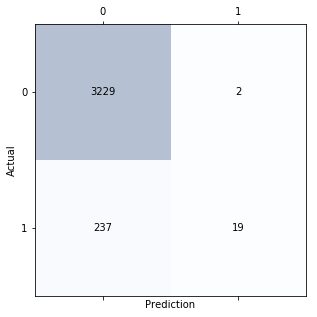

In [92]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center')
plt.xlabel('Prediction')
plt.ylabel('Actual')

In [93]:
metrics.precision_score(y_true=y_test, y_pred=y_pred)

0.9047619047619048

In [94]:
metrics.recall_score(y_true=y_test, y_pred=y_pred)

0.07421875

In [95]:
metrics.f1_score(y_true=y_test, y_pred=y_pred)

0.1371841155234657

In [118]:
# ROC Curve

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

probas = logreg.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test,
                                     probas[:, 1])

<Figure size 504x360 with 0 Axes>

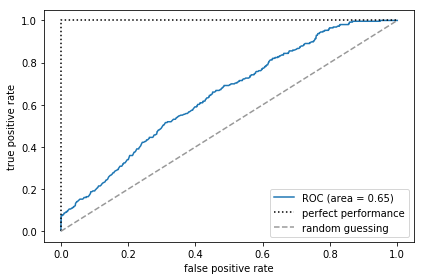

In [121]:
# ROC Curve


mean_tpr += interp(mean_fpr, fpr, tpr)
mean_tpr[0] = 0.0
roc_auc = auc(fpr, tpr)
plt.plot(fpr,
             tpr,
             label='ROC (area = %0.2f)' % roc_auc)

plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='perfect performance')


plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.savefig('data/06_10.png', dpi=300)
plt.show()


In [113]:
ROC_df = pd.DataFrame(probas)

In [114]:
ROC_df.to_csv("./data/ROC_df.csv")